In [1]:
import librosa
import librosa.display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import torch
import IPython.display as ipd
from IPython.display import Audio

from sklearn.model_selection import KFold, StratifiedKFold

In [2]:
meta = pd.read_csv('../../training.csv')
test_meta = pd.read_csv('../../test.csv')

## time

In [3]:
train_times = []
for name in meta['path']:
    y, sr = librosa.load('../../' + name)
    train_times.append(len(y)/ sr)
train_times = pd.Series(train_times)
train_times.describe()

count    2700.000000
mean        0.438810
std         0.149941
min         0.143537
25%         0.342268
50%         0.420590
75%         0.512653
max         2.282766
dtype: float64

Text(0.5, 1.0, 'train data time')

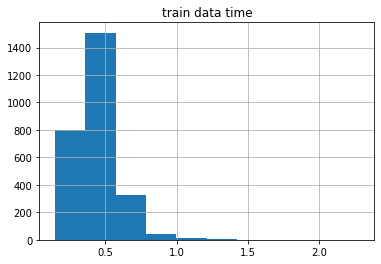

In [4]:
train_times.hist()
plt.title('train data time')

In [5]:
t = [item for item in train_times if item <= 1.0]
len(t)

2682

In [6]:
test_times = []
for name in test_meta['path']:
    y, sr = librosa.load('../../' + name)
    test_times.append(len(y)/ sr)
test_times = pd.Series(test_times)
test_times.describe()

count    300.000000
mean       0.425273
std        0.124639
min        0.195011
25%        0.342914
50%        0.410590
75%        0.493934
max        1.038639
dtype: float64

Text(0.5, 1.0, 'test data time')

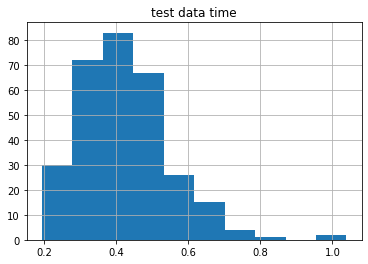

In [7]:
test_times.hist()
plt.title('test data time')

In [8]:
t = [item for item in test_times if item <= 1.0]
len(t)

298

In [9]:
long_audio_idxes = [i for i in range(len(train_times)) if train_times[i] > 1.0]
len(long_audio_idxes)

18

In [10]:
# for idx in long_audio_idxes:
#     y, sr = librosa.load('../../' + meta['path'].loc[int(idx)])
#     ipd.display(Audio(y, rate=sr))

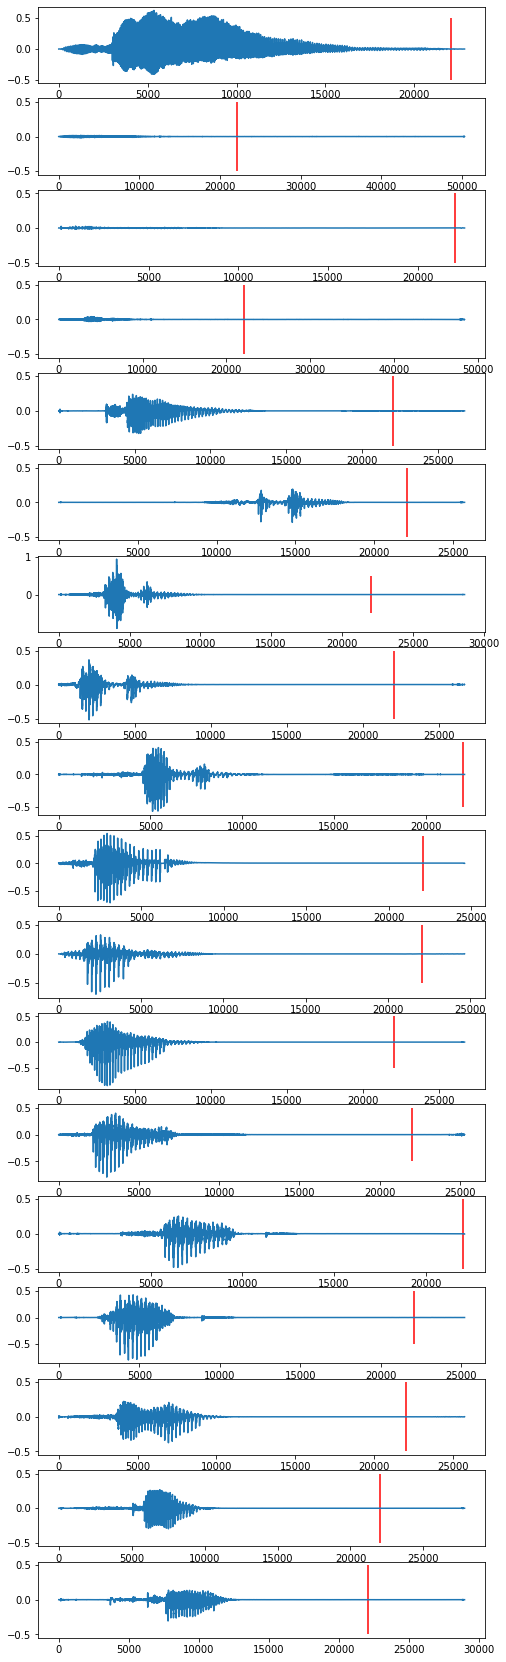

In [11]:
fig, axes = plt.subplots(len(long_audio_idxes), figsize=(8,30))
for i, idx in enumerate(long_audio_idxes):
    y, sr = librosa.load('../../' + meta['path'].loc[int(idx)])
    axes[i].plot(y)
    axes[i].vlines([sr], -0.5, 0.5, "red")

In [12]:
# # make new meta
# # meta = pd.read_csv('../training.csv')
# name_list = []
# label_list = []
# for i in range(len(meta)):
#     if train_times[i] <= 1.0:
#         name_list.append(meta['path'][i])
#         label_list.append(meta['label'][i])
# new_meta = pd.DataFrame(list(zip(name_list, label_list)), columns=['path', 'label'])
# # new_meta.to_csv('../new_training.csv', index=False)

In [13]:
# # make new meta
# name_list = []
# for i in range(len(test_meta)):
#     if test_times[i] <= 1.0:
#         name_list.append(test_meta['path'][i])
# df = pd.DataFrame(name_list, columns=['path'])
# df.to_csv('../new_test.csv', index=False)

### non silent interval

In [14]:
non_silent_intervals = []
for name in meta['path']:
    y, sr = librosa.load('../../' + name)
    non_silent_intervals.append(librosa.effects.split(y))

print(non_silent_intervals[0])

[[    0 11089]]


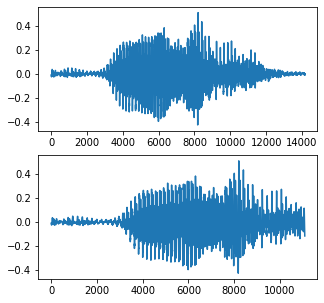

In [15]:
y, sr = librosa.load('../../' + meta['path'].loc[345])

plt.figure(figsize=(5, 5))
plt.subplot(2,1,1)
plt.plot(y)
plt.subplot(2,1,2)
plt.plot(y[0:11089])

Audio(y[0:11089], rate=sr)

In [16]:
train_times = []
for i, name in enumerate(meta['path']):
    start = non_silent_intervals[i][0][0]
    end = non_silent_intervals[i][0][1]
    
    y, sr = librosa.load('../../' + name)
    y = y[start:end]
    train_times.append(len(y)/ sr)
train_times = pd.Series(train_times)
train_times.describe()

count    2700.000000
mean        0.434158
std         0.139968
min         0.069660
25%         0.341939
50%         0.420136
75%         0.511247
max         2.282766
dtype: float64

Text(0.5, 1.0, 'train data time without silent interval')

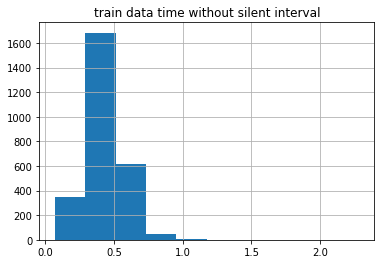

In [17]:
train_times.hist()
plt.title('train data time without silent interval')

In [18]:
long_audio_idxes = [i for i in range(len(train_times)) if train_times[i] > 0.75]
len(long_audio_idxes)

51

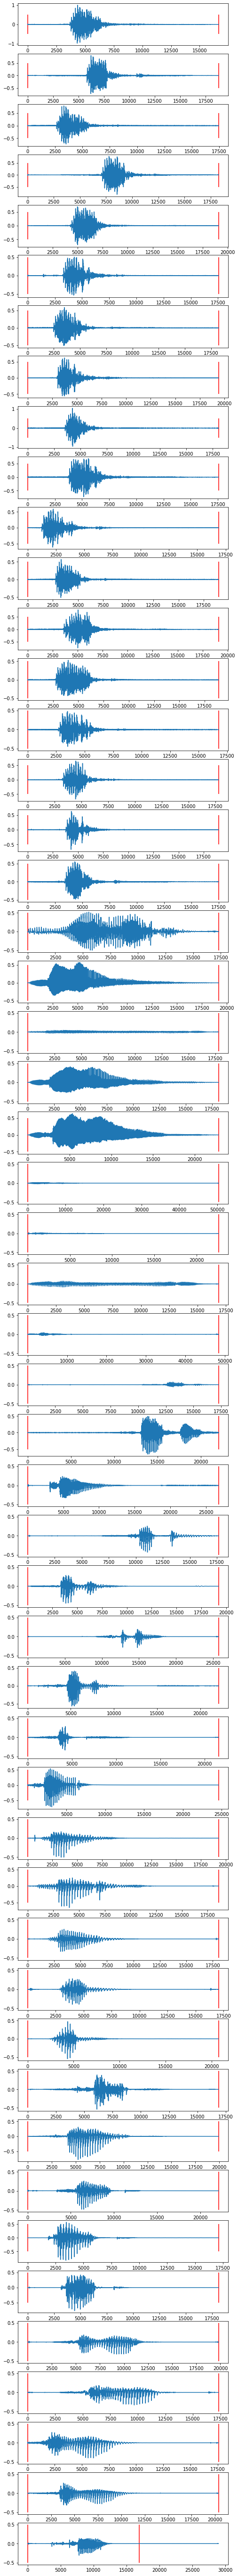

In [19]:
fig, axes = plt.subplots(len(long_audio_idxes), figsize=(8,100))
for i, idx in enumerate(long_audio_idxes):
    y, sr = librosa.load('../../' + meta['path'].loc[int(idx)])
    axes[i].plot(y)
    
    start = non_silent_intervals[idx][0][0]
    end = non_silent_intervals[idx][0][1]
    
    axes[i].vlines([start], -0.5, 0.5, "red")
    axes[i].vlines([end], -0.5, 0.5, "red")    

### relation of number and audio time

In [20]:
meta['times'] = train_times
meta.head()

,path,label,times
0,dataset/train/jackson_0.wav,4,0.502902
1,dataset/train/jackson_1.wav,4,0.429252
2,dataset/train/jackson_2.wav,4,0.484898
3,dataset/train/jackson_3.wav,4,0.440272
4,dataset/train/jackson_4.wav,4,0.454512


In [21]:
meta.groupby('label').describe()['times']

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
0,270.0,0.500685,0.117469,0.271791,0.405850,0.487528,0.591735,0.923628
1,270.0,0.398733,0.119102,0.174875,0.306757,0.377778,0.479592,0.941542
2,270.0,0.379872,0.123444,0.161043,0.288379,0.356576,0.471168,1.213379
3,270.0,0.396657,0.133145,0.181905,0.284966,0.381655,0.496814,0.766259
4,270.0,0.404534,0.112390,0.069660,0.329070,0.394512,0.469229,1.114875
5,270.0,0.446730,0.113845,0.069660,0.376531,0.422766,0.508866,1.025170
6,270.0,0.451522,0.179217,0.143537,0.319002,0.444195,0.569875,0.977506
7,270.0,0.455523,0.163681,0.245669,0.367370,0.438753,0.507336,2.195918
8,270.0,0.410754,0.104297,0.218639,0.342857,0.400703,0.467268,1.002902


## Baseline extract features

In [22]:
def feature_extraction(path_list):
    """
    wavファイルのリストから特徴抽出を行い，リストで返す
    扱う特徴量はMFCC13次元の平均（0次は含めない）
    Args:
        path_list: 特徴抽出するファイルのパスリスト
    Returns:
        features: 特徴量
    """

    load_data = (lambda path: librosa.load('../../' + path)[0])

    data = list(map(load_data, path_list))
    features = np.array([np.mean(librosa.feature.mfcc(y=y, n_mfcc=13), axis=1) for y in data])

    return features

In [23]:
# features = feature_extraction(list(meta['path']))
# features.shape

## kfold

<AxesSubplot:>

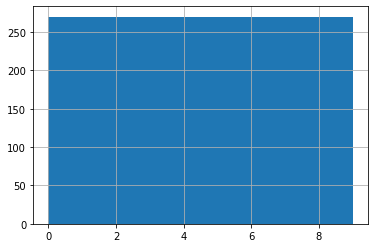

In [24]:
meta['label'].hist()

In [25]:
def plot_cv_indices(cv, X, y, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""
    
    cmap_data = plt.cm.Paired
    cmap_cv = plt.cm.coolwarm

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        # Fill in indices with the training/test
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)

    # Plot the data classes
    ax.scatter(range(len(X)), [ii + 1.5] * len(X), c=y, marker='_', lw=lw, cmap=cmap_data)

    # Formatting
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    return ax

In [26]:
# n_splits = 3
# idxes = [i for i in range(len(meta))]
# X = idxes
# y = meta['label'].values

# fig, ax = plt.subplots()
# cv = KFold(n_splits)

# plot_cv_indices(cv, X, y, ax, n_splits)

In [27]:
# fig, ax = plt.subplots()
# skf = StratifiedKFold(n_splits)
# plot_cv_indices(skf, X, y, ax, n_splits)

In [28]:
n_splits = 3
idxes = [i for i in range(len(meta))]
labels = meta['label'].values
cv = KFold(n_splits)

fold_tr_labels = {}
fold_val_labels = {}
for i, (tr_idx, val_idx) in enumerate(cv.split(idxes)):
    fold_tr_labels[str(i)] = labels[tr_idx]
    fold_val_labels[str(i)] = labels[val_idx]

array([[<AxesSubplot:title={'center':'0'}>,
        <AxesSubplot:title={'center':'1'}>],
       [<AxesSubplot:title={'center':'2'}>, <AxesSubplot:>]], dtype=object)

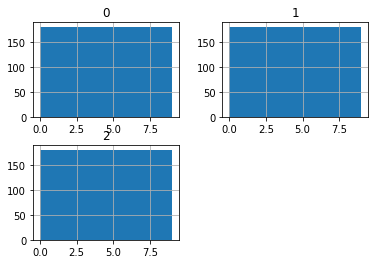

In [29]:
pd.DataFrame(fold_tr_labels).hist()

array([[<AxesSubplot:title={'center':'0'}>,
        <AxesSubplot:title={'center':'1'}>],
       [<AxesSubplot:title={'center':'2'}>, <AxesSubplot:>]], dtype=object)

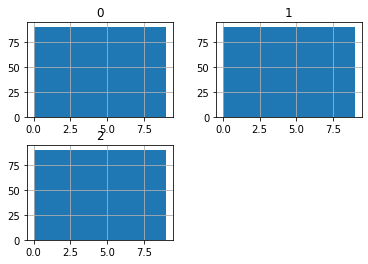

In [30]:
pd.DataFrame(fold_val_labels).hist()

## mel spectrogram

In [3]:
def mel_spec(input: np.ndarray, sr: int, win_size: int, hop_len: int, n_mels: int, fmax: int = 4096) -> np.ndarray:
    mel = librosa.feature.melspectrogram(
        y=input, sr=sr, n_mels=n_mels, fmax=fmax, n_fft=win_size, win_length=win_size, hop_length=hop_len)
    log_mel = librosa.amplitude_to_db(mel)

    # reverse
    log_mel = log_mel[::-1] - np.zeros_like(log_mel)

    return log_mel

In [4]:
y, sr = librosa.load('../../' + meta['path'].loc[456])
Audio(y, rate=sr)

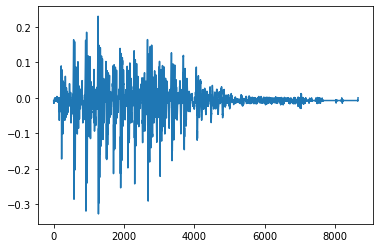

In [5]:
plt.plot(y)

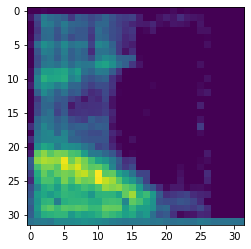

In [6]:
win_size = int(sr*0.025)
overlap = 0.5
n_mels = 32

logmel = mel_spec(y, sr, win_size, int(win_size*overlap), n_mels)
logmel = np.float32(logmel[:, :])
plt.imshow(logmel)

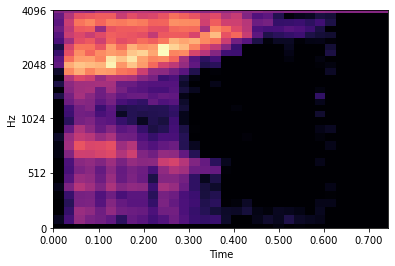

In [7]:
librosa.display.specshow(logmel, x_axis='time', y_axis='mel', sr=sr, fmax=4096)

## Volume

### RMS

In [23]:
train_max_rms = []
train_min_rms = []
for name in meta['path']:
    y, sr = librosa.load('../../' + name)
    rms = librosa.feature.rms(y)
    
    train_max_rms.append(rms.max())
    train_min_rms.append(rms.min())
train_rms = pd.DataFrame(list(zip(train_min_rms, train_max_rms)), columns=['min', 'max'])
train_rms.describe()

,min,max
count,2700.000000,2700.000000
mean,0.004832,0.084923
std,0.004982,0.062823
min,0.000059,0.003261
25%,0.000756,0.021371
50%,0.002617,0.083813
75%,0.008711,0.123801
max,0.058745,0.353766


Text(0.5, 1.0, 'train rms')

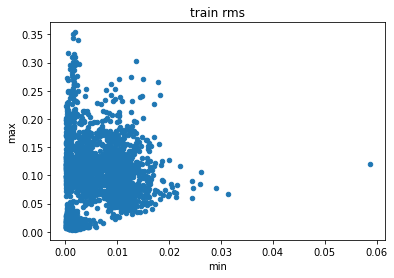

In [38]:
train_rms.plot.scatter(x='min', y='max')
plt.title('train rms')

In [32]:
test_max_rms = []
test_min_rms = []
for name in test_meta['path']:
    y, sr = librosa.load('../../' + name)
    rms = librosa.feature.rms(y)
    
    test_max_rms.append(rms.max())
    test_min_rms.append(rms.min())
test_rms = pd.DataFrame(list(zip(test_min_rms, test_max_rms)), columns=['min', 'max'])
test_rms.describe()

,min,max
count,300.000000,300.000000
mean,0.004651,0.085070
std,0.004563,0.063293
min,0.000078,0.005678
25%,0.000794,0.021903
50%,0.002569,0.083903
75%,0.008434,0.124840
max,0.018321,0.315530


Text(0.5, 1.0, 'test rms')

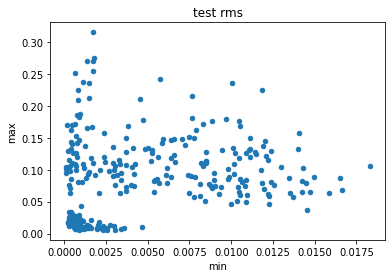

In [39]:
test_rms.plot.scatter(x='min', y='max')
plt.title('test rms')

### wave

In [34]:
train_max_dbs = []
train_min_dbs = []
for name in meta['path']:
    y, sr = librosa.load('../../' + name)
    train_max_dbs.append(y.max())
    train_min_dbs.append(y.min())
train_dbs = pd.DataFrame(list(zip(train_min_dbs, train_max_dbs)), columns=['min', 'max'])
train_dbs.describe()

,min,max
count,2700.000000,2700.000000
mean,-0.279941,0.223887
std,0.212060,0.172017
min,-1.012407,0.008771
25%,-0.415466,0.054367
50%,-0.268997,0.213309
75%,-0.075002,0.332886
max,-0.009601,1.040595


<AxesSubplot:xlabel='min', ylabel='max'>

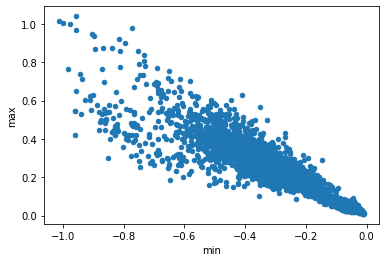

In [35]:
train_dbs.plot.scatter(x='min', y='max')

In [36]:
test_max_dbs = []
test_min_dbs = []
for name in test_meta['path']:
    y, sr = librosa.load('../../' + name)
    test_max_dbs.append(y.max())
    test_min_dbs.append(y.min())
test_dbs = pd.DataFrame(list(zip(test_min_dbs, test_max_dbs)), columns=['min', 'max'])
test_dbs.describe()

,min,max
count,300.000000,300.000000
mean,-0.287640,0.227697
std,0.220482,0.177917
min,-0.958323,0.014299
25%,-0.423605,0.055603
50%,-0.266880,0.212667
75%,-0.076413,0.335312
max,-0.012448,1.006432


<AxesSubplot:xlabel='min', ylabel='max'>

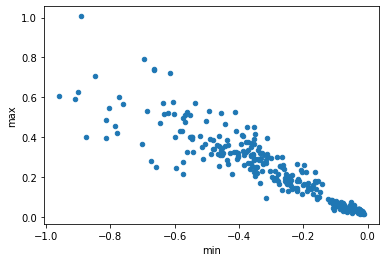

In [37]:
test_dbs.plot.scatter(x='min', y='max')

## SpecAugmentation

In [230]:
import torch
from torchlibrosa.augmentation import SpecAugmentation

Text(0.5, 1.0, 'SpecAug')

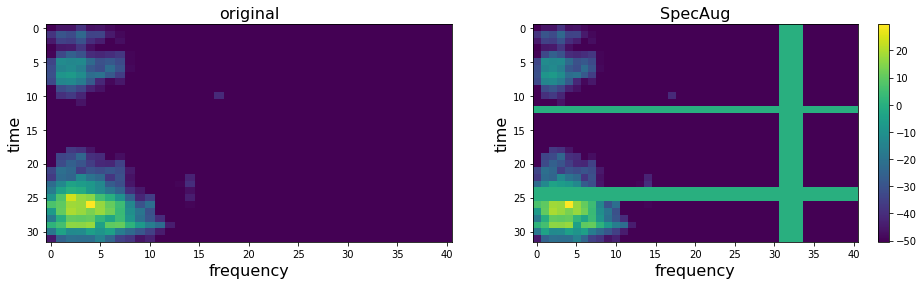

In [231]:
spec_augmenter = SpecAugmentation(
    time_drop_width=4, time_stripes_num=2, freq_drop_width=4, freq_stripes_num=2
)

win_size = int(sr*0.05)
overlap = 0.5
n_mels = 32
logmel = mel_spec(y, sr, win_size, int(win_size*overlap), n_mels)
logmel_ch = np.float32(logmel[np.newaxis, :, :])
logmel_tensor = torch.tensor(logmel_ch.copy()).unsqueeze(0)

augmented = spec_augmenter(logmel_tensor)
augmented = augmented.squeeze(0).squeeze(0).numpy()

plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.imshow(logmel, aspect="auto")
plt.xlabel("frequency", size=16)
plt.ylabel("time", size=16)
plt.title("original", size=16)
plt.subplot(1, 2, 2)
plt.imshow(augmented, aspect="auto")
plt.colorbar()
plt.xlabel("frequency", size=16)
plt.ylabel("time", size=16)
plt.title("SpecAug", size=16)

## Augmentation

### add gaussian noise

In [28]:
def add_gaussian_noise(input, max_noise_amplitude=0.1):
    noise_amplitude = np.random.uniform(0.0, max_noise_amplitude)
    noise = np.random.randn(len(input))
    augmented = (input + noise * noise_amplitude).astype(input.dtype)
    
    return augmented

In [29]:
y, sr = librosa.load('../../' + meta['path'].loc[0])
y_augmented = add_gaussian_noise(y)
Audio(y_augmented, rate=sr)

Text(0.5, 1.0, 'add gaussian noise')

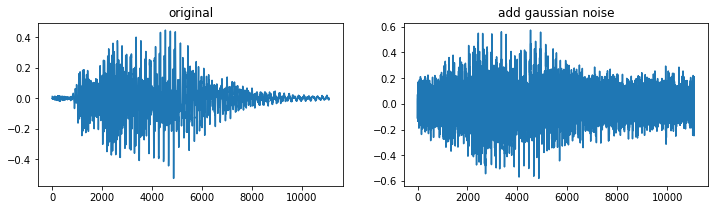

In [30]:
plt.figure(figsize=(12, 3))

plt.subplot(1,2,1)
plt.plot(y)
plt.title('original')

plt.subplot(1,2,2)
plt.plot(y_augmented)
plt.title('add gaussian noise')

Text(0.5, 1.0, 'add gaussian noise')

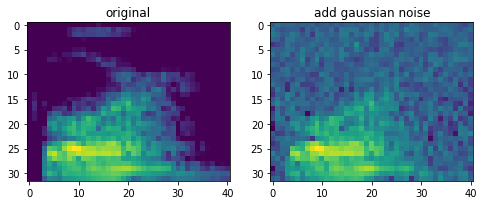

In [31]:
plt.figure(figsize=(8, 8))

plt.subplot(1,2,1)
feature = mel_spec(y, sr, int(sr*0.025), int(win_size*0.5), 32)
feature = np.float32(feature)
plt.imshow(feature)
plt.title('original')

plt.subplot(1,2,2)
feature = mel_spec(y_augmented, sr, int(sr*0.025), int(win_size*0.5), 32)
feature = np.float32(feature)
plt.imshow(feature)
plt.title('add gaussian noise')

### gaussian noise SNR

In [32]:
def gaussian_noise_snr(input, min_snr=5.0, max_snr=20.0):
    snr = np.random.uniform(min_snr, max_snr)
    a_signal = np.sqrt(input ** 2).max()
    a_noise = a_signal / (10 ** (snr / 20))
    
    white_noise = np.random.randn(len(input))
    a_white = np.sqrt(white_noise ** 2).max()
    augmented = (input + white_noise * 1 / a_white * a_noise).astype(y.dtype)
    
    return augmented

In [33]:
y, sr = librosa.load('../../' + meta['path'].loc[0])
y_augmented = gaussian_noise_snr(y)
Audio(y_augmented, rate=sr)

Text(0.5, 1.0, 'add gaussian noise')

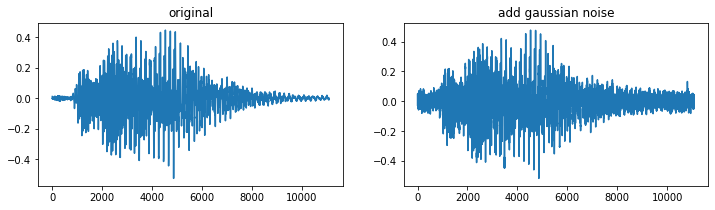

In [34]:
plt.figure(figsize=(12, 3))

plt.subplot(1,2,1)
plt.plot(y)
plt.title('original')

plt.subplot(1,2,2)
plt.plot(y_augmented)
plt.title('add gaussian noise')

Text(0.5, 1.0, 'add gaussian noise')

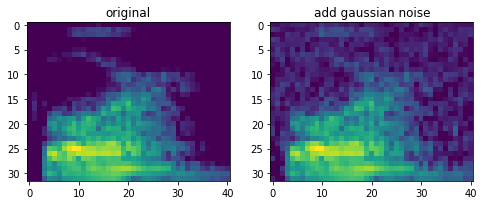

In [35]:
plt.figure(figsize=(8, 8))

plt.subplot(1,2,1)
feature = mel_spec(y, sr, int(sr*0.025), int(win_size*0.5), 32)
feature = np.float32(feature)
plt.imshow(feature)
plt.title('original')

plt.subplot(1,2,2)
feature = mel_spec(y_augmented, sr, int(sr*0.025), int(win_size*0.5), 32)
feature = np.float32(feature)
plt.imshow(feature)
plt.title('add gaussian noise')

In [36]:
pip install colorednoise

You should consider upgrading via the '/home/kajiwara21/work/B4Lecture-2021/ex_9/kajiwara/kajiwara_env/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [37]:
import colorednoise as cn
def pink_noise_snr(input, min_snr=5.0, max_snr=20.0):
    snr = np.random.uniform(min_snr, max_snr)
    a_signal = np.sqrt(y ** 2).max()
    a_noise = a_signal / (10 ** (snr / 20))

    pink_noise = cn.powerlaw_psd_gaussian(1, len(y))
    a_pink = np.sqrt(pink_noise ** 2).max()
    augmented = (y + pink_noise * 1 / a_pink * a_noise).astype(y.dtype)
    return augmented

In [38]:
y, sr = librosa.load('../../' + meta['path'].loc[0])
y_augmented = pink_noise_snr(y)
Audio(y_augmented, rate=sr)

Text(0.5, 1.0, 'add gaussian noise')

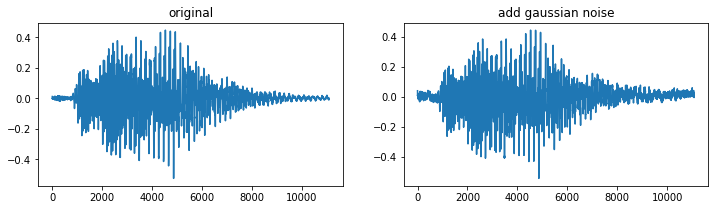

In [39]:
plt.figure(figsize=(12, 3))

plt.subplot(1,2,1)
plt.plot(y)
plt.title('original')

plt.subplot(1,2,2)
plt.plot(y_augmented)
plt.title('add gaussian noise')

Text(0.5, 1.0, 'add gaussian noise')

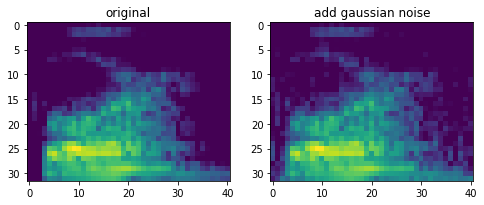

In [40]:
plt.figure(figsize=(8, 8))

plt.subplot(1,2,1)
feature = mel_spec(y, sr, int(sr*0.025), int(win_size*0.5), 32)
feature = np.float32(feature)
plt.imshow(feature)
plt.title('original')

plt.subplot(1,2,2)
feature = mel_spec(y_augmented, sr, int(sr*0.025), int(win_size*0.5), 32)
feature = np.float32(feature)
plt.imshow(feature)
plt.title('add gaussian noise')

### pitch shift

In [41]:
def pitch_shift(input, sr, max_steps=5):
    n_steps = np.random.randint(-max_steps, max_steps)
    augmented = librosa.effects.pitch_shift(y, sr=sr, n_steps=n_steps)
    return augmented

In [42]:
y, sr = librosa.load('../../' + meta['path'].loc[0])
y_augmented = pitch_shift(y, sr)
Audio(y_augmented, rate=sr)

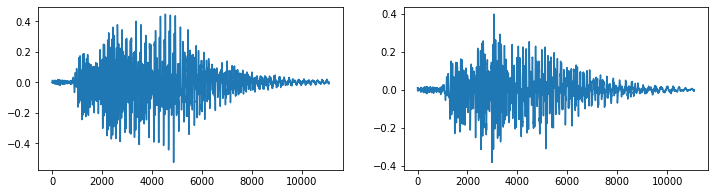

In [43]:
plt.figure(figsize=(12, 3))

plt.subplot(1,2,1)
plt.plot(y)

plt.subplot(1,2,2)
plt.plot(y_augmented)

Text(0.5, 1.0, 'pitch shift')

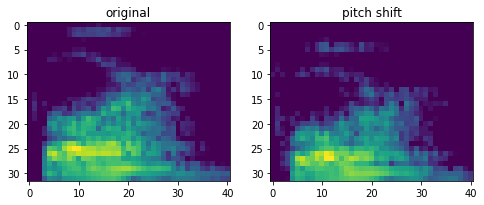

In [44]:
plt.figure(figsize=(8, 8))

plt.subplot(1,2,1)
feature = mel_spec(y, sr, int(sr*0.025), int(win_size*0.5), 32)
feature = np.float32(feature)
plt.imshow(feature)
plt.title('original')

plt.subplot(1,2,2)
feature = mel_spec(y_augmented, sr, int(sr*0.025), int(win_size*0.5), 32)
feature = np.float32(feature)
plt.imshow(feature)
plt.title('pitch shift')

### Time Shift

In [45]:
def time_shift(input, sr, max_shift_second=0.3, padding_mode='replace'):
    shift = np.random.randint(-sr*max_shift_second, sr*max_shift_second)
    augmented = np.roll(input, shift)
    if padding_mode == "zero":
        if shift > 0:
            augmented[:shift] = 0
        else:
            augmented[shift:] = 0
    return augmented

In [46]:
y, sr = librosa.load('../../' + meta['path'].loc[0])
y = y[:sr]
y_augmented = time_shift(y, sr)
Audio(y_augmented, rate=sr)

Text(0.5, 1.0, 'time shift')

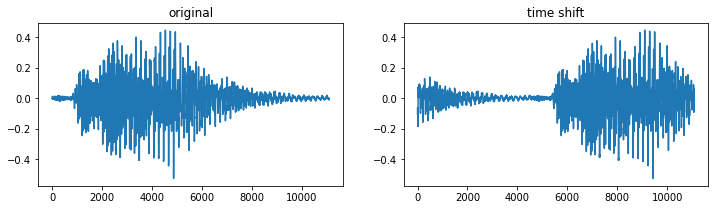

In [47]:
plt.figure(figsize=(12, 3))

plt.subplot(1,2,1)
plt.plot(y)
plt.title('original')

plt.subplot(1,2,2)
plt.plot(y_augmented)
plt.title('time shift')

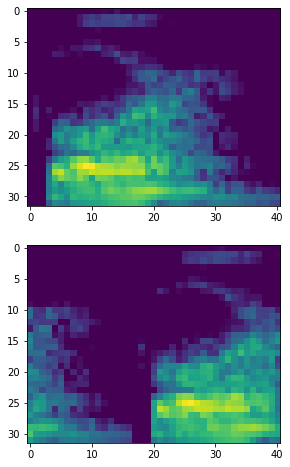

In [48]:
plt.figure(figsize=(8, 8))

plt.subplot(2,1,1)
feature = mel_spec(y, sr, int(sr*0.025), int(win_size*0.5), 32)
feature = np.float32(feature)
plt.imshow(feature)

plt.subplot(2,1,2)
feature = mel_spec(y_augmented, sr, int(sr*0.025), int(win_size*0.5), 32)
feature = np.float32(feature)
plt.imshow(feature)

### Time Stretch

In [49]:
def time_stretch(input, max_rate=1.2):
    rate = np.random.uniform(0, max_rate)
    augmented = librosa.effects.time_stretch(input, rate)
    
    return augmented

In [50]:
y, sr = librosa.load('../../' + meta['path'].loc[0])
y_augmented = time_stretch(y)
Audio(y_augmented, rate=sr)

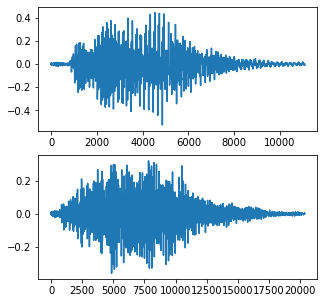

In [51]:
plt.figure(figsize=(5, 5))

plt.subplot(2,1,1)
plt.plot(y)

plt.subplot(2,1,2)
plt.plot(y_augmented)

Text(0.5, 1.0, 'time stretch')

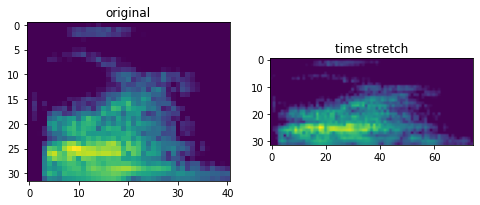

In [52]:
plt.figure(figsize=(8, 8))

plt.subplot(1,2,1)
feature = mel_spec(y, sr, int(sr*0.025), int(win_size*0.5), 32)
feature = np.float32(feature)
plt.imshow(feature)
plt.title('original')

plt.subplot(1,2,2)
feature = mel_spec(y_augmented, sr, int(sr*0.025), int(win_size*0.5), 32)
feature = np.float32(feature)
plt.imshow(feature)
plt.title('time stretch')

### Volume Controll

In [76]:
def volume_control(input, db_lim=15, mode='sine'):
    """
    mode must be one of 'uniform', 'fade', 'cosine', 'sine'
    """

    db = np.random.uniform(-db_lim, db_lim)
    
    if mode == "uniform":
        db_translated = 10 ** (db / 20)
    elif mode == "fade":
        lin = np.arange(len(input))[::-1] / (len(input) - 1)
        db_translated = 10 ** (db * lin / 20)
    elif mode == "cosine":
        cosine = np.cos(np.arange(len(input)) / len(input) * np.pi * 2)
        db_translated = 10 ** (db * cosine / 20)
    else:
        sine = np.sin(np.arange(len(input)) / len(input) * np.pi * 2)
        db_translated = 10 ** (db * sine / 20)

    augmented = input * db_translated
    
    return augmented

In [54]:
y, sr = librosa.load('../../' + meta['path'].loc[0])
y_augmented = volume_control(y, mode='cosine')
Audio(y_augmented, rate=sr)

Text(0.5, 1.0, 'volume control')

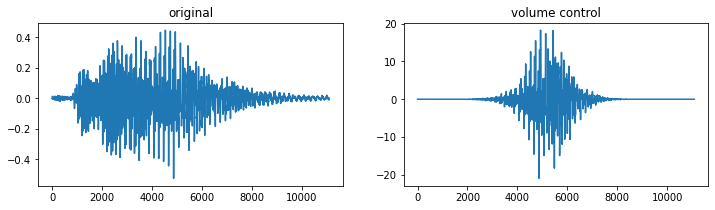

In [55]:
plt.figure(figsize=(12, 3))

plt.subplot(1,2,1)
plt.plot(y)
plt.title('original')

plt.subplot(1,2,2)
plt.plot(y_augmented)
plt.title('volume control')

Text(0.5, 1.0, 'volume control')

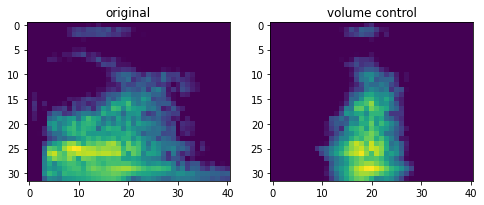

In [56]:
plt.figure(figsize=(8, 8))

plt.subplot(1,2,1)
feature = mel_spec(y, sr, int(sr*0.025), int(win_size*0.5), 32)
feature = np.float32(feature)
plt.imshow(feature)
plt.title('original')

plt.subplot(1,2,2)
feature = mel_spec(y_augmented, sr, int(sr*0.025), int(win_size*0.5), 32)
feature = np.float32(feature)
plt.imshow(feature)
plt.title('volume control')

### all

In [71]:
y, sr = librosa.load('../../' + meta['path'].loc[0])
Audio(y, rate=sr)

In [72]:
y = pitch_shift(y, sr)
Audio(y, rate=sr)

In [73]:
y = time_shift(y, sr)
Audio(y, rate=sr)

In [74]:
y = volume_control(y, mode='cosine')
Audio(y, rate=sr)

In [75]:
y = gaussian_noise_snr(y)
Audio(y, rate=sr)

### mixup

In [201]:
def mixup(data, label, batch_size, alpha = 0.2):
    l = np.random.beta(alpha, alpha, batch_size)
    x_, y_ = sklearn.utils.shuffle(data, label)
    
    shape = tuple(-1 if i == 0 else 1 for i in range(len(data.shape)))
    mixed_data = l.reshape(shape) * data + (1 - l).reshape(shape) * x_
    
    shape = tuple(-1 if i == 0 else 1 for i in range(len(label.shape)))
    mixed_label = l.reshape(shape) * label + (1 - l).reshape(shape) * y_
    
    return mixed_data, mixed_label

In [202]:
y, sr = librosa.load('../../' + meta['path'].loc[0])
if len(y) <= 1.0*sr:
    y = np.append(y, np.array(
        [0] * (int(1.0*sr) - len(y))))
else:
    y = y[:int(1.0*sr)]
sample = mel_spec(y, sr, int(sr*0.025), int(win_size*0.5), 32)

batch_data = np.zeros((5, *sample.shape))
batch_labels = np.zeros(5)
for i in range(0, 500, 100):
    y, sr = librosa.load('../../' + meta['path'].loc[i])
    if len(y) <= 1.0*sr:
        y = np.append(y, np.array(
            [0] * (int(1.0*sr) - len(y))))
    else:
        y = y[:int(1.0*sr)]
    spec = mel_spec(y, sr, int(sr*0.025), int(win_size*0.5), 32)
    
    batch_data[i//100] = spec
    batch_labels[i//100] = meta['label'].loc[i]

batch_data.shape

(5, 32, 81)

In [203]:
mixed_data, mixed_label = mixup(batch_data, batch_labels, 5)
mixed_label

array([7.05645973, 4.03633668, 3.00463653, 2.44535244, 7.3377805 ])

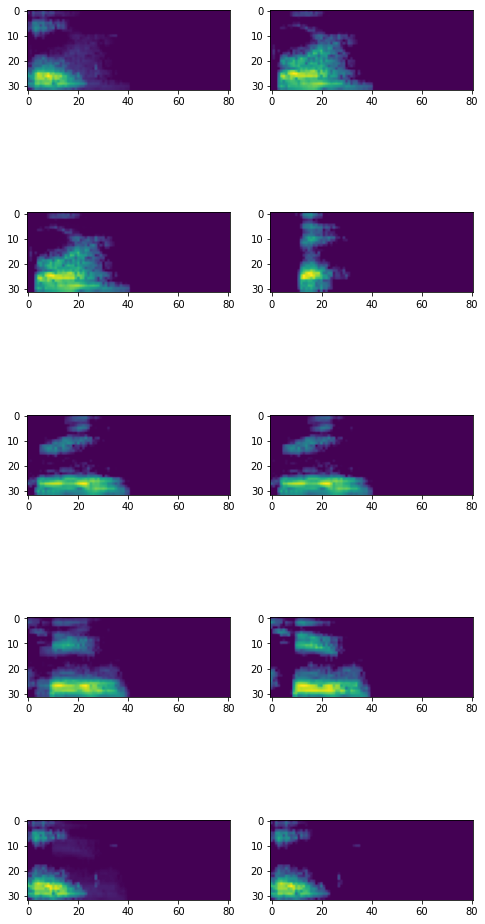

In [204]:
fig, axes = plt.subplots(5, 2, figsize=(8,18))
for i, img in enumerate(mixed_data):
    axes[i][0].imshow(img)
    axes[i][1].imshow(batch_data[i])

In [209]:
def mixup_data(x, y, alpha=0.2, use_cuda=True):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    
    return mixed_x, y_a, y_b, lam

In [228]:
mixed_x, y_a, y_b, lam = mixup_data(torch.Tensor(batch_data[:2]), torch.Tensor(batch_labels[:2]), use_cuda=False)

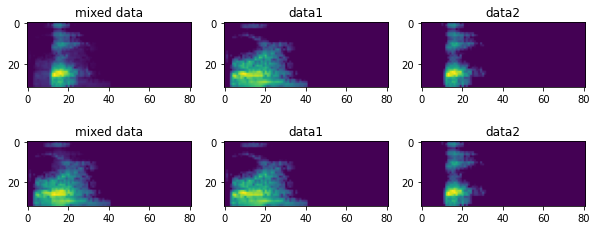

In [229]:
fig, axes = plt.subplots(2, 3, figsize=(10,4))
for i, img in enumerate(mixed_x.tolist()):
    axes[i][0].imshow(img)
    axes[i][0].set_title('mixed data')
    
    axes[i][1].imshow(batch_data[0])
    axes[i][1].set_title('data1')
    
    axes[i][2].imshow(batch_data[1])
    axes[i][2].set_title('data2')